# Retrieve molecules by target (UniProt accession code)

This tutorial gives a deeper understanding of the pipeline for creating a molecule collection with the same 
target. 

In [3]:
from modtox.modtox.Molecules.target_col import CollectionFromTarget, RetrievalSummary
from modtox.modtox.utils.enums import Database, Features, StandardTypes

In this example we use *Candida albicans* Chitin synthase 1 (P23316) because it has targets among the three
databases. After creating the object, we fetch to the databases.  
>Note: fetching PubChem takes much more time than the other two.* 

In [ ]:
c = CollectionFromTarget("P00740")  # 5tnt
dbs = [Database.BindingDB, Database.ChEMBL, Database.PubChem]
c.fetch(dbs)

After fetching, three variables have been created:
1. Activities: list of `modtox.Activities` objects
2. IDs: Dict as {database -> {inchi: id}}
3. PubChem Activity: Dict as {inchi: pubchem_tag}

In [ ]:
c.activities

Also, we can take a look at one activity. Each activity stores:
   - A standard
   - InChI of the molecule
   - Database where it has been retrieved
   - Target

In [ ]:
activity = c.activities[0]
print("Activity standard: ", activity.standard)
print("Activity retrieved from: ", activity.database.name)
print(f"Molecule InChI: {activity.inchi[:20]}[...]{activity.inchi[-20:]}")
print("Molecule target: ", activity.target)

And we can also access the standard information:

In [ ]:
print("Standard type: ", activity.standard.std_type.name)  # std_type is an instance of modtox.StandardTypes(Enum)
print("Standard relation: ", activity.standard.std_rel)
print("Standard value: ", activity.standard.std_val)
print("Standard unit: ", activity.standard.std_unit)

The retrieved IDs are in a Python dictionary as: {database -> {inchi: id}}. It is very likely that we have retrieved the same molecule in two databases:

In [ ]:
inchi = 'InChI=1S/C18H20N2O/c1-18(2,3)12-5-4-6-13-19-15-8-7-9-16-14(15)10-11-17(21)20-16/h4,6-11,19H,13H2,1-3H3,(H,20,21)/b6-4+'
print("BDBM: ", c.ids[Database.BindingDB][inchi])
print("ChEMBL ID: ", c.ids[Database.ChEMBL][inchi])

We can unify the ids in a `modtox.IDs` object. For that, we will first need to store all the InChIs, without duplicates.

In [ ]:
c.get_unique_inchis()
for i, inchi in enumerate(c.unique_inchis):
    print(f"{i}: {inchi[:20]}[...]{inchi[-20:]}")

In [ ]:
c._unify_ids()
for inchi, id in c.unified_ids.items():
    inchi_ab = f"{inchi[0:20]}[...]{inchi[-20:]}"
    print(inchi_ab, id)

So, the retrieved activities and molecules are:

In [ ]:
print("Retrieved activities: ", len(c.activities))
print("Retrieved molecules: ", len(c.unique_inchis))

We can take a look at the plotted summaries (saved as `.png`) and the activities table (saved as `.csv`).

In [ ]:
import pickle5 as p
with open("P00740.pickle", "wb") as f:
    p.dump(c, f)

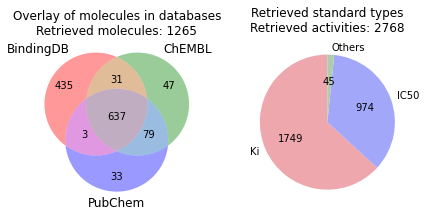

In [1]:
import pickle5 as p
with open("P00740.pickle", "rb") as f:
    c = p.load(f)
c.summarize_retrieval()

In [4]:
rs = RetrievalSummary(c)
act_tab = rs._activities_table()
#act_tab.to_csv("P00740_act_table.csv")
act_tab

,Activities,Molecules,Avg stdev,Units,Activities/molecule
Ki,1749,669,54.492,nM,2.61435
IC50,974,567,2.37324,nM,1.71781
Kobs_1,12,12,0,M-1 s-1,1
Inhibition,19,19,0,%,1
Activity,12,11,1926.54,%,1.09091
Papp,1,1,0,cm/s,1
Efficacy,1,1,0,%,1


We can have an idea of the variability of the data. For example, for Ki there are 2.6 reported activites per molecules with reported Ki. However, the average standard deviation of the reported Kis for each of
the 9 molecules is 0, meaning all the reported activities match. 

Now we will create the `modtox.Molecule` instances. That will allow us to access more functionalities such as saving the data, Tanimoto clustering...  Each molecule stores:
- The molecule __name__ (defined as target + int)
- Molecule __IDs__ to map to databases.
- __Activities__ which can be accessed as shown before.
- `rdkit.Mol` object

In [ ]:
c.create_molecules()

Finally, we can classify the compounds between active and inactive setting our threshold.   For each criterion, molecules can be classified as: 
- __Active:__ all reported activities fall below the threshold. 
- __Inactive:__ all reported activities fall above the threshold.
- __No data:__ no reported activities (for this standard type).
- __Contradictory data:__ reported activities fall both above and below the threshold.  

In addition, we can also use the PubChem criteria: `c.pubchem_activity` {inchi -> ['Active', ...]}, defined during `c.fetch()`, for which:
- __Active:__ all reported activities are 'Active'. 
- __Inactive:__ all reported activities are 'Inactive'.
- __No data:__ no reported activities.
- __Contradictory data:__ reported activities are both 'Active' and 'Inactive' or there are 'Unspecified' tags.

In [ ]:
criteria = {
    StandardTypes.Ki: 100,
    "pubchem": 0, # Value provided is ignored. 
    StandardTypes.IC50: 100,    
}
c.assess_activity(criteria)

And we can take a look at each molecule activity tags for each criteria:

In [ ]:
mol = c.molecules[0]
print("Activities:")
for activity in mol.activities:
    print(f"\t{activity}")
pubchem_activities = c.pubchem_activity[mol.inchi]
for activity in pubchem_activities:
    print(f"\tPubChem: {activity}")
print(f"Activity tags: {mol.activity_tags}")

To have a more general idea, we can take a look at our activity assessment:

In [ ]:
assess = rs._activity_assessment_table()
assess.to_csv("P00740_act_assess.csv")
assess

We can save the `modtox.Collection` object as it is and recover it later using Pickle. By default, saved in current working directory with the name `{target}.pickle`.

In [ ]:
c.to_pickle()

To load the collection, simply:

In [ ]:
import pickle5
with open("P23316.pickle", "rb") as f:
    c = pickle5.load(f)
c.target

The collection can also be exported to SDF. It will add the properties to each molecule `rdkit.Mol` object so it can be read later. 
> *Note:* the activity stored in the `.sdf` file corresponds to the first criterion supplied. In this case, Ki, 100 nM.

In [ ]:
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')  # Disable warnings (AddHs)
c.to_sdf(output=None)

In [ ]:
# Displaying a molecule sdf file
with open("P23316.sdf", "r") as f:
    lines = f.readlines()
for line in lines[1590:1689]:
    print(line.strip())